# Modeling and Simulation in Python

Chapter 7: Thermal systems

Copyright 2017 Allen Downey

License: [Creative Commons Attribution 4.0 International](https://creativecommons.org/licenses/by/4.0)


We'll start with the same code we saw last time: the magic command that tells Jupyter where to put the figures, and the import statement that gets the function defined in the `modsim` module.

In [1]:
# If you want the figures to appear in the notebook, 
# and you want to interact with them, use
# %matplotlib notebook

# If you want the figures to appear in the notebook, 
# and you don't want to interact with them, use
# %matplotlib inline

# If you want the figures to appear in separate windows, use
# %matplotlib qt|

# tempo switch from one to another, you have to select Kernel->Restart

%matplotlib inline

from modsim import *

### The coffee cooling problem.

I'll use a `State` object to store the initial temperature.


In [2]:
init = State(temp=90)
init

,value
temp,90


And a `System` object to contain the system parameters.

In [3]:
coffee = System(init=init, T_env=22, r=0.01,
                t0=0, t_end=30, dt=1)
coffee

,value
init,temp 90 dtype: int64
T_env,22
r,0.01
t0,0
t_end,30
dt,1


The `update` function implements Newton's law of cooling.

In [4]:
def update(system, state):
    """Update the thermal transfer model.
    
    system: System object
    state: State (temp)
    
    returns: State (temp)
    """
    T = state.temp
    dT = - system.r * (T - system.T_env) * system.dt
    return State(temp=T+dT)

Here's how it works.

In [5]:
update(coffee, init)

,value
temp,89.32


Now we can run simulations using the same function from the previous chapter.

In [6]:
def run_simulation(system, update_func):
    """Runs a simulation of the system.
    
    Add a DataFrame to the System: results
    
    system: System object
    update_func: function that updates state
    """
    df = TimeFrame(columns=system.init.index)
    df.loc[system.t0] = system.init
    
    for i in arange(system.t0, system.t_end):
        df.loc[i+1] = update_func(system, df.loc[i])
    
    system.results = df

And here's how it works.

In [7]:
run_simulation(coffee, update)
coffee.results

,temp
0,90
1,89.32
2,88.6468
3,87.9803
4,87.3205
5,86.6673
6,86.0207
7,85.3804
8,84.7466
9,84.1192


Here's what the results look like.

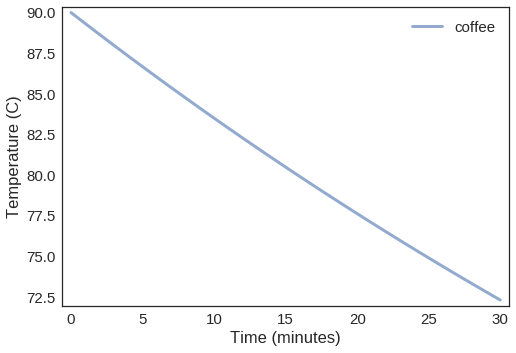

In [8]:
plot(coffee.results.temp, label='coffee')
decorate(xlabel='Time (minutes)',
         ylabel='Temperature (C)')

After running the simulation, we can extract the final temperature from the results.

In [9]:
def final_temp(system):
    """Final temperature.
    
    system: System object with results.
    
    returns: temperature (C)
    """
    # TODO: if there are no results, return init.temp? 
    df = system.results
    return df.temp[system.t_end]

It will be convenient to wrap these steps in a function.  `kwdargs` is a collection of whatever keyword arguments are provided; they are passed along as arguments to `System`.

In [10]:
def run(T_init, **kwdargs):
    """Runs a simulation with the given parameters.
    
    volume: volume of liquid
    kwdargs: collection of keyword arguments
    
    returns: System object
    """
    init = State(temp=T_init)
    system = System(init=init, T_env=22, t0=0, 
                    dt=1, **kwdargs)
    run_simulation(system, update)
    return system

Here's how we use it:

In [11]:
coffee = run(T_init=90, t_end=30, r=0.01)
final_temp(coffee)

72.2996253904031

**Exercise:**  To make sure you understand how `kwdargs` works, add a print statement at the beginning of `run` and see what the value of `kwdargs` is.

### Using `fsolve`

As a simple example, let's find the roots of this function; that is, the values of `x` that make the result 0.

In [12]:
def func(x):
    return (x-1) * (x-2) * (x-3)

`modsim.py` provides `fsolve`, which does some error-checking and then runs `scipy.optimize.fsolve`.  The first argument is the function whose roots we want.  The second argument is an initial guess.

In [13]:
fsolve(func, x0=0)

array([ 1.])

Usually the root we get is the one that's closest to the initial guess.

In [14]:
fsolve(func, 1.9)

array([ 2.])

In [15]:
fsolve(func, 2.9)

array([ 3.])

But not always.

In [16]:
fsolve(func, 1.5)

array([ 3.])

We want to find the value of `r` that makes the final temperature 70, so we define an "error function" that takes `r` as a parameter and returns the difference between the final temperature and the goal.

In [17]:
def error_func1(r):
    """Runs a simulation and returns the `error`.
    
    r: thermal insulation factor
    
    returns: difference between final temp and 70C
    """
    system = run(T_init=90, t_end=30, r=r)
    return final_temp(system) - 70

With `r=0.01`, we end up a little too warm.

In [18]:
error_func1(r=0.01)

2.2996253904030937

The return value from `fsolve` is an array with a single element, the estimated value of `r`.

In [19]:
solution = fsolve(error_func1, 0.01, xtol=1e-8)
r_coffee = solution[0]
r_coffee

0.011543084583978345

If we run the simulation with the estimated value of `r`, the final temperature is 70 C, as expected.

In [20]:
coffee = run(T_init=90, t_end=30, r=r_coffee)
final_temp(coffee)

70.0

**Exercise:**  When you call `fsolve`, it calls `error_func1` several times.  To see how this works, add a print statement to `error_func1` and run `fsolve` again.

**Exercise:** Repeat this process to estimate `r_milk`, given that it starts at 5 C and reaches 20 C after 15 minutes.  

Before you use `fsolve`, you might want to try a few values for `r_milk` and see how close you can get by trial and error.  Here's an initial guess to get you started:

In [21]:
r_milk = 0.1
milk = run(T_init=5, t_end=15, r=r_milk)
final_temp(milk)

18.499850754390966

In [22]:
# Solution

def error_func2(r):
    """Runs a simulation and returns the `error`.
    
    r: thermal insulation factor
    
    returns: difference between final temp and 20C
    """
    system = run(T_init=5, t_end=15, r=r)
    return final_temp(system) - 20

In [23]:
# Solution

error_func2(r=0.1)

-1.500149245609034

In [24]:
# Solution

solution = fsolve(error_func2, 0.1, xtol=1e-8)
r_milk = solution[0]
r_milk

0.13296078935466457

In [25]:
# Solution

milk = run(T_init=5, t_end=15, r=r_milk)
final_temp(milk)

20.0

Here's what the results look like.

Saving figure to file chap07-fig01.pdf


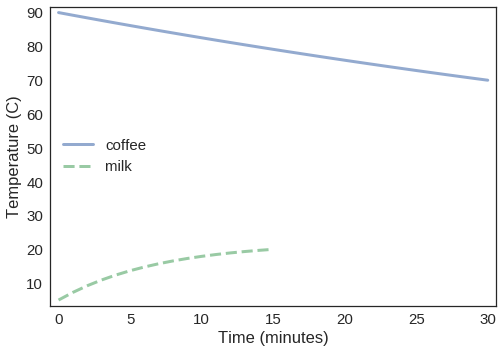

In [26]:
plot(coffee.results.temp, label='coffee')
plot(milk.results.temp, '--', label='milk')
decorate(xlabel='Time (minutes)',
         ylabel='Temperature (C)',
         loc='center left')

savefig('chap07-fig01.pdf')

### Mixing liquids

We can figure out the final temperature of a mixture by setting the total heat flow to zero and then solving for $T$.

In [27]:
sympy.init_printing() 

from sympy import symbols, Eq, solve

C1, C2, T1, T2, T = symbols('C1 C2 T1 T2 T')

eq = Eq(C1 * (T - T1) + C2 * (T - T2), 0)
eq

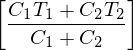

In [28]:
solve(eq, T)

The following function takes `System` object that represent two liquids, computes the temperature of the mixture, creates a new `System` object and runs a simulation.

In [29]:
def mix(s1, s2, t_end=0):
    """Simulates the mixture of two liquids after t_end minutes.
    
    s1: System
    s2: System
    t_end: number of minutes to simulate
    """
    assert s1.t_end == s2.t_end
    
    volume = s1.volume + s2.volume
    
    temp = (s1.volume * final_temp(s1) + 
            s2.volume * final_temp(s2)) / volume
    
    mixture = run(T_init=temp, t_end=t_end, 
                  r=s1.r, volume=volume)
    
    return mixture

Here's what we get if we add the milk at the end.

In [30]:
coffee = run(T_init=90, t_end=30, r=r_coffee, volume=300)
final_temp(coffee)

In [31]:
milk = run(T_init=5, t_end=30, r=r_milk, volume=50)
final_temp(milk)

In [32]:
mix_last = mix(coffee, milk)
final_temp(mix_last)

And here's what we get if we add the milk immediately.

In [33]:
coffee = run(T_init=90, t_end=0, r=r_coffee, volume=300)
milk = run(T_init=5, t_end=0, r=r_milk, volume=50)

In [34]:
mix_first = mix(coffee, milk, t_end=30)
final_temp(mix_first)

The following function takes `t_add`, which is the time when the milk is added, and returns the final temperature.

In [35]:
def run_and_mix(t_add):
    """Simulates two liquids and them mixes them at t_add.
    
    t_add: time in minutes
    
    returns: final temperature
    """
    coffee = run(T_init=90, t_end=t_add, r=r_coffee, volume=300)
    milk = run(T_init=5, t_end=t_add, r=r_milk, volume=50)
    mixture = mix(coffee, milk, t_end=30-t_add)
    return final_temp(mixture)

We can try it out with a few values.

In [36]:
run_and_mix(0)

In [37]:
run_and_mix(15)

In [38]:
run_and_mix(30)

And then sweep a range of values for `t_add`

In [39]:
sweep = Sweep()
for t_add in arange(0, 31):
    temp = run_and_mix(t_add)
    sweep[t_add] = temp

Here's what the result looks like.

Saving figure to file chap07-fig02.pdf


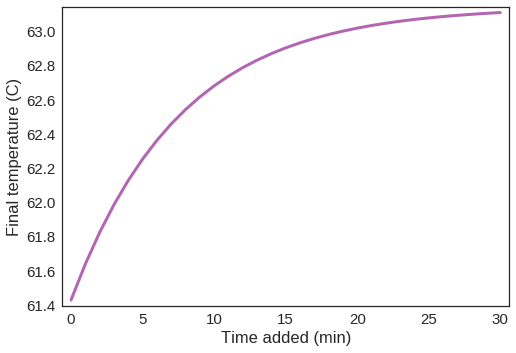

In [40]:
plot(sweep, color='purple')
decorate(xlabel='Time added (min)',
         ylabel='Final temperature (C)',
         legend=False)

savefig('chap07-fig02.pdf')

**Exercise:**  Suppose the coffee shop won't let me take milk in a separate container, but I keep a bottle of milk in the refrigerator at my office.  In that case is it better to add the milk at the coffee shop, or wait until I get to the office?

Hint: Think about the simplest way to represent the behavior of a refrigerator in this model.  The change you make to test this variation of the problem should be very small!

### Analysis

We can use SymPy to solve the cooling differential equation.

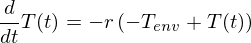

In [41]:
from sympy import symbols, Function, diff, Eq, dsolve

T_init, T_env, r, t = symbols('T_init T_env r t')
T = symbols('T', cls=Function)

eqn = Eq(diff(T(t), t), -r * (T(t) - T_env))
eqn

In [42]:
solution_eq = dsolve(eqn)
solution_eq

In [43]:
general = solution_eq.rhs
general

We can use the initial condition to solve for $C_1$.  First we evaluate the general solution at $t=0$

In [44]:
at0 = general.subs(t, 0)
at0

Now we set $T(0) = T_{init}$ and solve for $C_1$

In [45]:
solutions = solve(Eq(at0, T_init), C1)
value_of_C1 = solutions[0]
value_of_C1

Then we plug the result into the general solution to get the particular solution:

In [46]:
particular = general.subs(C1, value_of_C1)
particular

We use a similar process to estimate $r$ based on the observation $T(t_{end}) = T_{end}$

In [47]:
t_end, T_end = symbols('t_end T_end')

Here's the particular solution evaluated at $t_{end}$

In [48]:
at_end = particular.subs(t, t_end)
at_end

Now we set $T(t_{end}) = T_{end}$ and solve for $r$

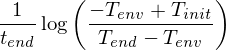

In [49]:
solutions = solve(Eq(at_end, T_end), r)
value_of_r = solutions[0]
value_of_r

We can use `evalf` to plug in numbers for the symbols.  The result is a SymPy float, which we have to convert to a Python float.

In [50]:
subs = dict(t_end=30, T_end=70, T_init=90, T_env=22)
r_coffee2 = value_of_r.evalf(subs=subs)
type(r_coffee2)

sympy.core.numbers.Float

In [51]:
r_coffee2 = float(r_coffee2)
r_coffee2

Now we can use the analytic result to compute temperature as a function of time.  The following function is similar to `run_simulation`.

In [52]:
def run_analysis(system):
    """Computes temperature using the analytic solution.
    
    system: System object
    """
    T_init = system.init.temp
    T_env = system.T_env
    
    ts = arange(system.t0, system.t_end+1)
    Ts = T_env + (T_init - T_env) * np.exp(-system.r * ts)
    series = TimeSeries(Ts, index=ts)
    
    system.results = TimeFrame(series, columns=['temp'])

Here's how we run it.

In [53]:
init = State(temp=90)
coffee2 = System(init=init, T_env=22, r=r_coffee2, 
                 t0=0, t_end=30)
run_analysis(coffee2)
final_temp(coffee2)

And we can compare to the results from simulation.

In [54]:
init = State(temp=90)
coffee = System(init=init, T_env=22, r=r_coffee, 
                t0=0, t_end=30, dt=1)
run_simulation(coffee, update)
final_temp(coffee)

They are identical except for small roundoff errors.

In [55]:
coffee.results - coffee2.results

,temp
0,0
1,0
2,0
3,0
4,0
5,0
6,0
7,0
8,0
9,0
